# Libraries

In [1]:
import numpy as np # linear algebra

import tensorflow_text as tf_text

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras import Model, Input

# Read data

In [3]:
import pandas as pd # data processing and csv 
test = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
train_data = pd.read_csv("/kaggle/input/data-llm/data_llm.csv")

In [4]:
# data cleaning (removing starting [, '," and ending [, ', ")
train_data['text'] = train_data['text'].str.strip('["]')
train_data['text'] = train_data['text'].str.strip("['']")


In [5]:
train_final = train_data
train_final

,text,generated
0,"Pigs and humans are genetically very similar ,...",0.0
1,Buildings often leave their lights on all nigh...,1.0
2,There are a few reasons why humans might prefe...,1.0
3,Cracking your knuckles is a common habit that ...,1.0
4,"People who are sick , young children , the eld...",0.0
...,...,...
40149,Crude oil is a complex mixture of various hydr...,1.0
40150,Historically low interest rates can affect rea...,1.0
40151,Kernel methods are a class of algorithms for p...,1.0
40152,It also reduces risk from the bank's eyes. Bel...,0.0


In [6]:
print(train_final.iloc[0])

text         Pigs and humans are genetically very similar ,...
generated                                                  0.0
Name: 0, dtype: object


# Stats

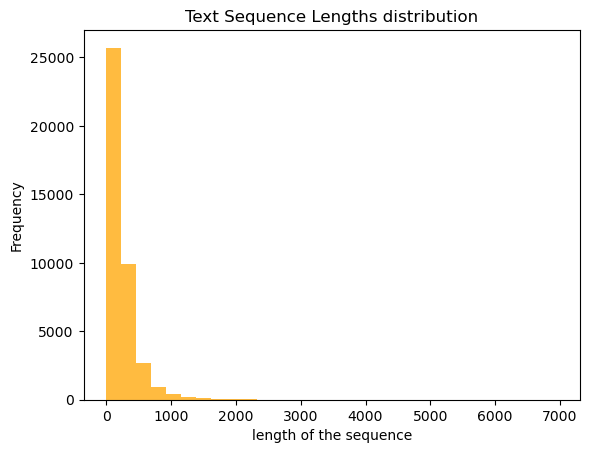

In [7]:
import matplotlib.pyplot as plt
length_of_sequences = train_final['text'].apply(lambda x: len(x.split()))
plt.hist(length_of_sequences, bins=30, alpha=0.75, color='orange')

plt.xlabel('length of the sequence')
plt.ylabel('Frequency')
plt.title('Text Sequence Lengths distribution')
plt.show()

In [8]:
print(train_final['generated'].value_counts())

generated
1.0    20415
0.0    19738
Name: count, dtype: int64


# Split data

In [9]:
training_dataframe, value_dataframe = train_test_split(train_final, test_size=0.3, random_state=10)

batch_size = 32  #32

raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (training_dataframe['text'].values, training_dataframe['generated'].values)
).batch(batch_size)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (value_dataframe['text'].values, value_dataframe['generated'].values)
).batch(batch_size)

# Vectorize

In [11]:
dimension_of_embeddings = 128  #64
length_sequence = 512
max_features = 75000

def tf_lower_and_split_punct(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text


# Text vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_features,
    ngrams = (3,5),
    output_mode="int",
    output_sequence_length=length_sequence,
    pad_to_max_tokens=True
)

text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

# NN trans

In [18]:

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# NN create

In [21]:
inputs = Input(shape=(length_sequence,), dtype="int64")
x = Embedding(max_features, dimension_of_embeddings)(inputs)
x = Bidirectional(LSTM(64, return_sequences=True))(x)  #32

transformer_block = TransformerBlock(dimension_of_embeddings, 2, 64)  #32
x = transformer_block(x)

x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", name="predictions")(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

# Training results on CPU with max_features = 75000, batch_size = 32 64 32 32 128, epochs = 1

# Training results on GPU (P100) with max_features = 75000, batch_size = 32 128 64 64 128, epochs = 3

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 512, 128)          9600000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 128)         98816     
 nal)                                                            
                                                                 
 transformer_block_1 (Transf  (None, 512, 128)         149056    
 ormerBlock)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 169, 128)          114816    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0   

# NN fit

In [20]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])

epochs = 2
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/2
879/879 [==============================] - 1732s 2s/step - loss: nan - binary_accuracy: 0.5366 - val_loss: nan - val_binary_accuracy: 0.4915
Epoch 2/2
555/879 [=================>............] - ETA: 9:37 - loss: nan - binary_accuracy: 0.4892

KeyboardInterrupt: 

# Results

In [14]:
test_text = test['text'].values
vectorized_test_text = vectorize_layer(test_text)
predictions = model.predict(vectorized_test_text)
test['generated'] = predictions
print(test[['text', 'generated']])

1/1 [==============================] - 1s 852ms/step
           text  generated
0  Aaa bbb ccc.   0.991725
1  Bbb ccc ddd.   0.991725
2  CCC ddd eee.   0.991725


In [ ]:
test[['id', 'generated']].set_index('id').to_csv("submission.csv")